In [1]:
import os
import cv2
import random
import torch
import numpy as np
from PIL import Image
from utils.DiffusionUtils import DiffusionUtils
from utils.TemplateManager import TemplateManager
from utils.exp_utils import list_concept_names, list_exp_names
from utils.img_utils import (
    otsu_thresholding, load_image, gaussian_noise, 
    resize, resize_and_center_crop, horizontal_filp, normalize_image
)

from ptp.AttentionControls import AttentionStore
from ptp.ptp_utils import text2image_ldm_stable, view_images
from ptp.attn_utils import aggregate_attention, show_cross_attention, show_self_attention_comp

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [2]:
def get_image_latent(img_path):
    image = Image.open(img_path).resize((512, 512))
    image = np.expand_dims(image, axis=0)
    image_latent = torch.tensor(DiffusionUtils.image2latent(image[:,:,:,:3]), dtype=torch.float16).to(DiffusionUtils.device)
    return image_latent

In [3]:
dataset_name = "BackData_clip"
cpt_name = "backpack_dog"
node = "v0"
# exp_name, seed = "0_InspirationTree", -1
exp_name, seed = "1_Proposed", 0
exp_path = f"/home/jack/Code/Research/instree_analysis/experiments/{dataset_name}/{exp_name}"

if seed == -1:
    concept_path = f"{exp_path}/outputs/{cpt_name}/{node}/learned_embeds.bin"
else:
    concept_path = f"{exp_path}/outputs/{cpt_name}/{node}/{node}_seed{seed}/learned_embeds.bin"

img_dataset_name = "BackData_clip"
origin_img_path = f"/home/jack/Code/Research/instree_analysis/experiment_data/{img_dataset_name}/{cpt_name}/v0/"
img_names = os.listdir(origin_img_path)
origin_img_path += random.choice(img_names)
print(f"origin_img_path: {origin_img_path}")


concepts = torch.load(concept_path)
DiffusionUtils.reset_vocab()
DiffusionUtils.add_new_vocab('<sl>', concepts['<*>'])
DiffusionUtils.add_new_vocab('<sr>', concepts['<&>'])

origin_img_path: /home/jack/Code/Research/instree_analysis/experiment_data/BackData_clip/backpack_dog/v0/01.jpg
Vocabulary has been reset.
Current vocab size:  49408
New token added:  <sl>
Current vocab size:  49409
All new tokens:  {'<sl>': 49408}
New token added:  <sr>
Current vocab size:  49410
All new tokens:  {'<sl>': 49408, '<sr>': 49409}


In [4]:
paper_concept_path = "/home/jack/Code/Research/instree_main/assets/paper_tokens.bin"
paper_concepts = torch.load(paper_concept_path)
print(paper_concepts.keys())
DiffusionUtils.reset_vocab()

for cpt in paper_concepts.keys():
    if cpt =='bear':
        DiffusionUtils.add_new_vocab(f"<sl>", paper_concepts[cpt][f"<{cpt}_v1>"])
        DiffusionUtils.add_new_vocab(f"<sr>", paper_concepts[cpt][f"<{cpt}_v2>"])

dict_keys(['cat', 'bear', 'buddha', 'mug', 'teapot', 'round_bird', 'elephant', 'wooden_pot', 'physics_mug', 'red_teapot', 'mug_buildings'])
Vocabulary has been reset.
Current vocab size:  49408
New token added:  <sl>
Current vocab size:  49409
All new tokens:  {'<sl>': 49408}
New token added:  <sr>
Current vocab size:  49410
All new tokens:  {'<sl>': 49408, '<sr>': 49409}


In [5]:
# cpt_name = 'D_backpack_dog'
# origin_img_path = f"/home/jack/Code/Research/instree_analysis/experiment_data/{dataset_name}/{exp_name}/{cpt_name}/v0/"
# img_names = os.listdir(origin_img_path)
# if ".DS_Store" in img_names:
#     img_names.remove(".DS_Store")
# origin_img_path += random.choice(img_names)
# print(f"origin_img_path: {origin_img_path}")

In [6]:
def analyze_attention_map(prompt, image_path=None, mode="cross", seed=0):
    torch.manual_seed(seed)
    controller = AttentionStore()
    latent = None if image_path is None else get_image_latent(image_path)
    step = 25 if latent is None else 1

    images, x_t = text2image_ldm_stable(
        DiffusionUtils.pipe, 
        [prompt],
        controller, 
        latent=latent, 
        num_inference_steps=step, guidance_scale=7.5, 
        generator=None, low_resource=False)
    view_images(images)
    s = 1

    result = {}
    if mode == "cross":
        attn_map_8, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, ["", prompt], controller, res=8, from_where=("mid",), select=s)
        attn_map_16, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, ["", prompt], controller, res=16, from_where=("up", "down"), select=s)
        attn_map_32, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, ["", prompt], controller, res=32, from_where=("up", "down"), select=s)
        attn_map_64, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, ["", prompt], controller, res=64, from_where=("up", "down"), select=s)
    elif mode == "self":
        attn_map_8 = show_self_attention_comp(["", prompt], controller, res=8, from_where=("mid",), select=s)
        attn_map_16 = show_self_attention_comp(["", prompt], controller, res=16, from_where=("up", "down"), select=s)
        attn_map_32 = show_self_attention_comp(["", prompt], controller, res=32, from_where=("up", "down"), select=s)
        attn_map_64 = show_self_attention_comp(["", prompt], controller, res=64, from_where=("up", "down"), select=s)
    else:
        raise ValueError("Invalid mode. Choose either 'cross' or 'self'.")
    
    result["attn_8"] = attn_map_8
    result["attn_16"] = attn_map_16
    result["attn_32"] = attn_map_32
    result["attn_64"] = attn_map_64
    result["text"] = text if mode == "cross" else None
    result["image"] = images[0]
    
    controller.reset()
    return result

  0%|          | 0/26 [00:00<?, ?it/s]

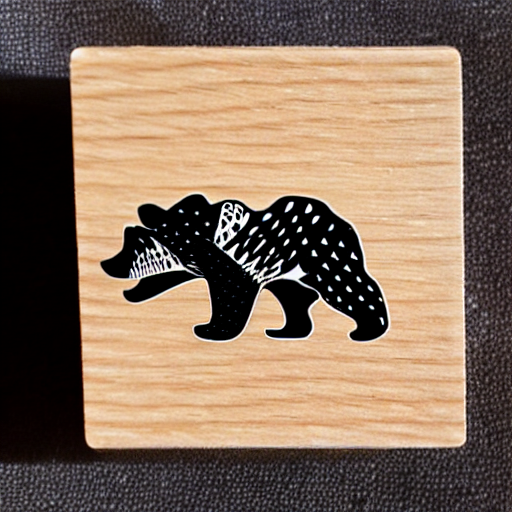

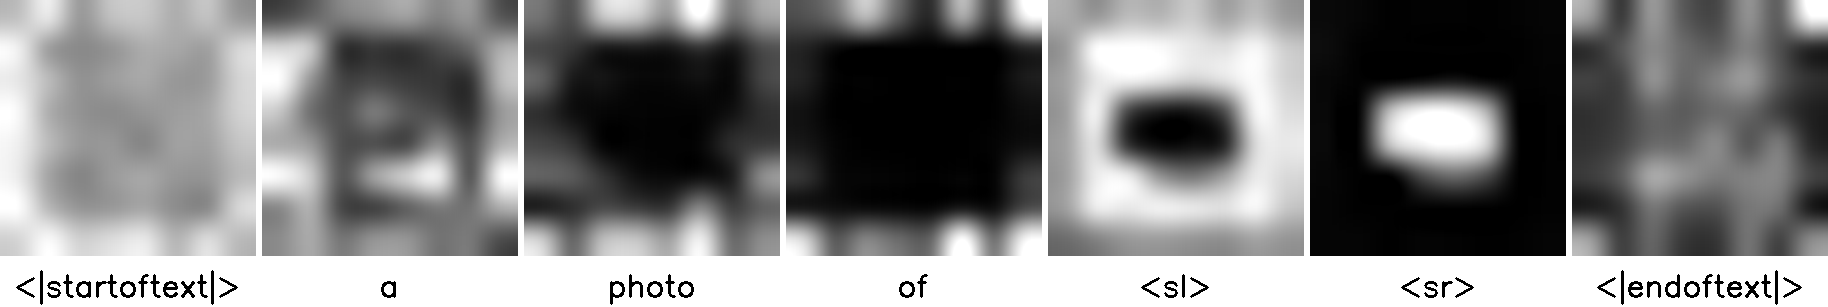

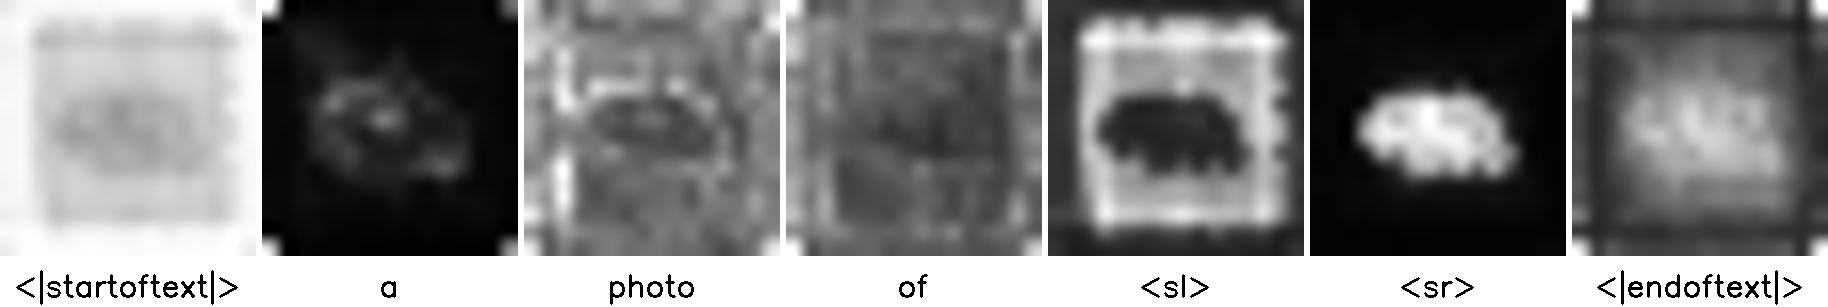

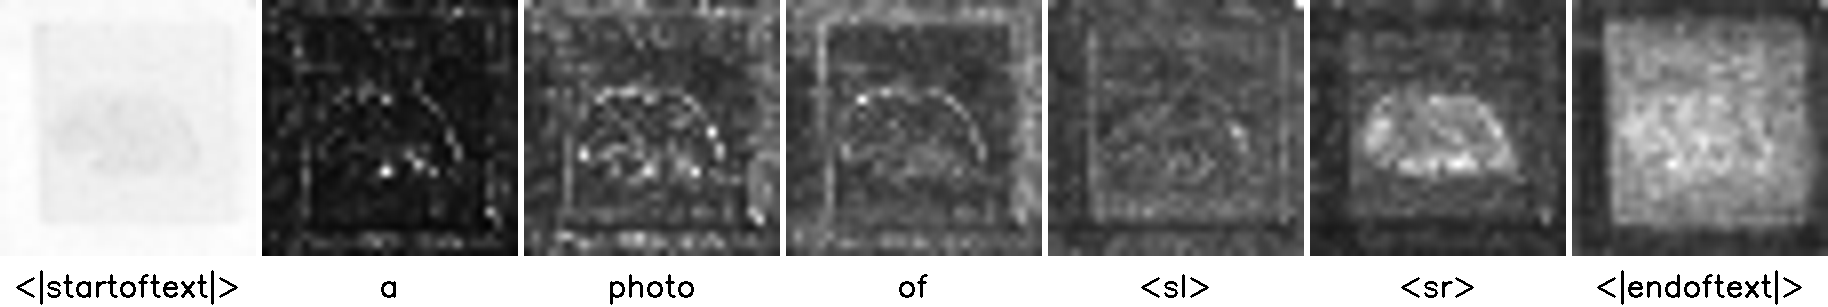

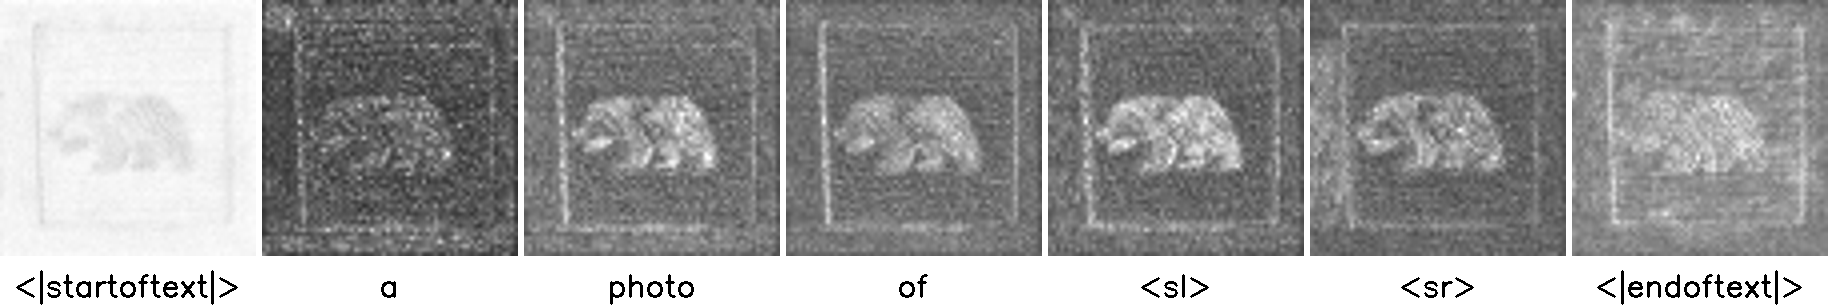

In [7]:
# prompt = TemplateManager.get_random_template("IMG").format("<bear_sl> <bear_sr>")
prompt = "a photo of {}".format("<sl> <sr>")
result = analyze_attention_map(prompt)

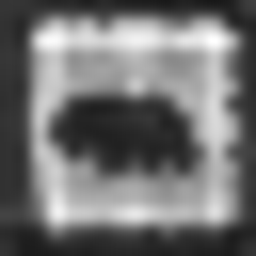

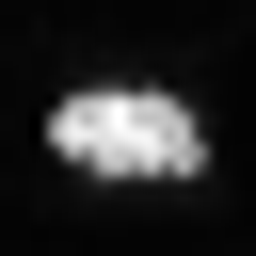

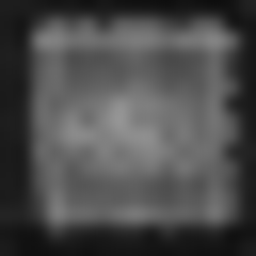

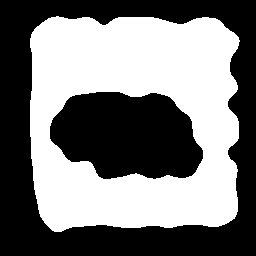

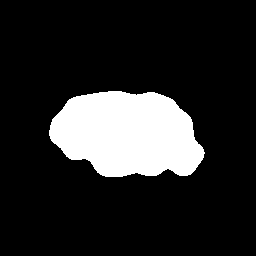

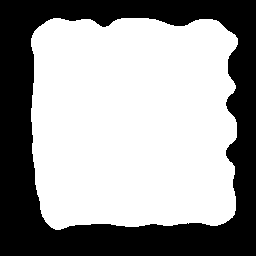

In [8]:
# v1_mask = result['attn_16'][4]
# v2_mask = result['attn_16'][5]
# v1_v2_mask = (v1_mask + v2_mask) // 2

v1_mask = result['attn_16'][4].astype(np.float32)
v2_mask = result['attn_16'][5].astype(np.float32)
v1_v2_mask = (v1_mask + v2_mask) / 2.0


v1_mask = resize_and_center_crop(v1_mask, 256)
v2_mask = resize_and_center_crop(v2_mask, 256)
v1_v2_mask = resize_and_center_crop(v1_v2_mask, 256)

view_images(v1_mask)
view_images(v2_mask)
view_images(v1_v2_mask)
v1_mask = otsu_thresholding(v1_mask.astype(np.uint8))
v2_mask = otsu_thresholding(v2_mask.astype(np.uint8))
v1_v2_mask = otsu_thresholding(v1_v2_mask.astype(np.uint8))

view_images(v1_mask)
view_images(v2_mask)
view_images(v1_v2_mask)

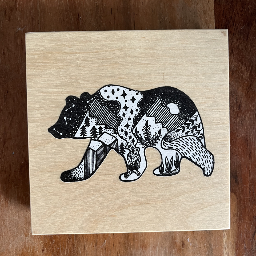

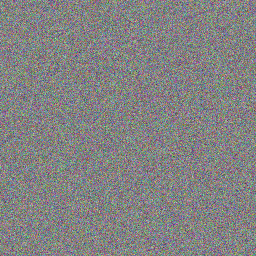

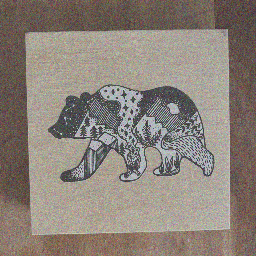

In [10]:
bear = load_image("/home/jack/Code/Research/instree_analysis/experiment_data/InsData_clip/canada_bear/v0/IMG_4223 Large.png")
bear = resize_and_center_crop(bear, 256).astype(np.float32)
view_images(bear)
noise = gaussian_noise(256).astype(np.float32)
view_images(noise)
noisy_bear = (bear + noise) / 2.0
view_images(noisy_bear)

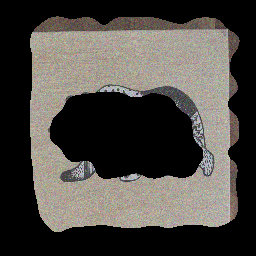

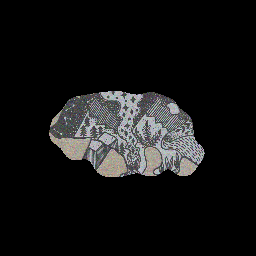

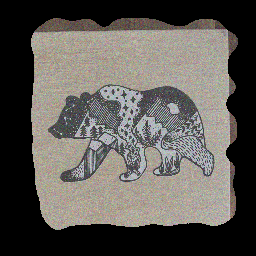

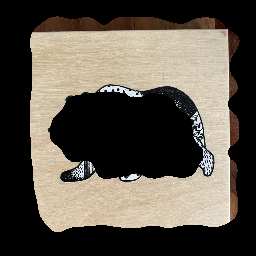

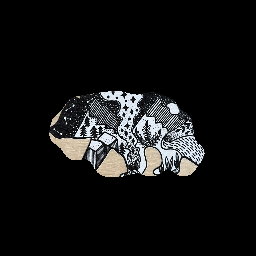

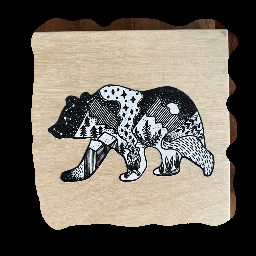

In [11]:
view_images(noisy_bear * (v1_mask / 255))
view_images(noisy_bear * (v2_mask / 255))
view_images(noisy_bear * (v1_v2_mask / 255))
view_images(bear * (v1_mask / 255))
view_images(bear * (v2_mask / 255))
view_images(bear * (v1_v2_mask / 255))

In [ ]:
get_image_latent(origin_img_path).shape

torch.Size([1, 4, 64, 64])

  0%|          | 0/26 [00:00<?, ?it/s]

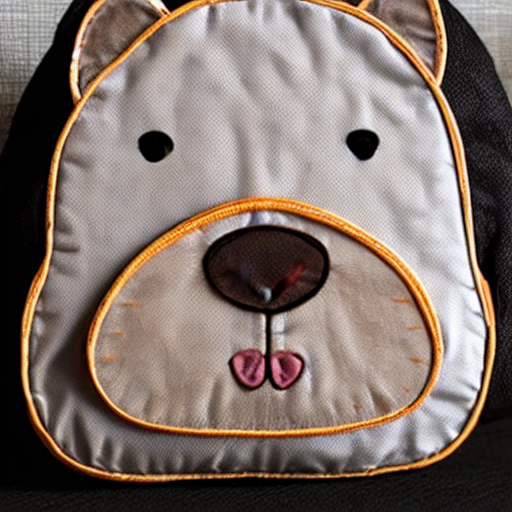

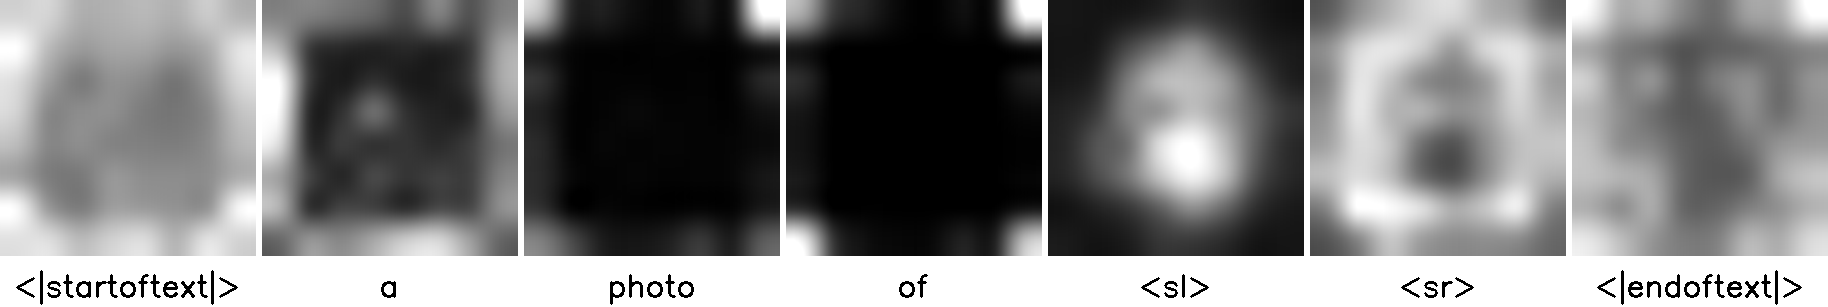

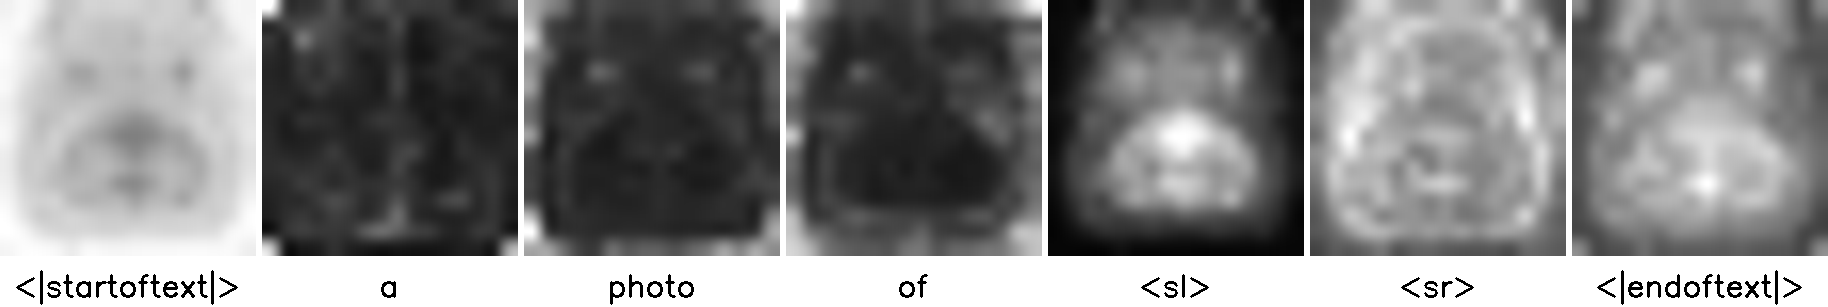

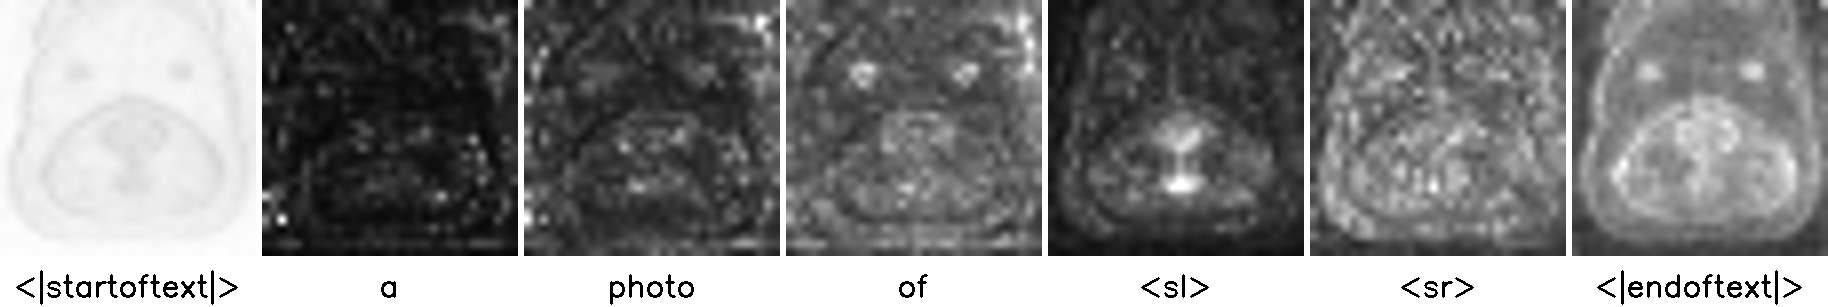

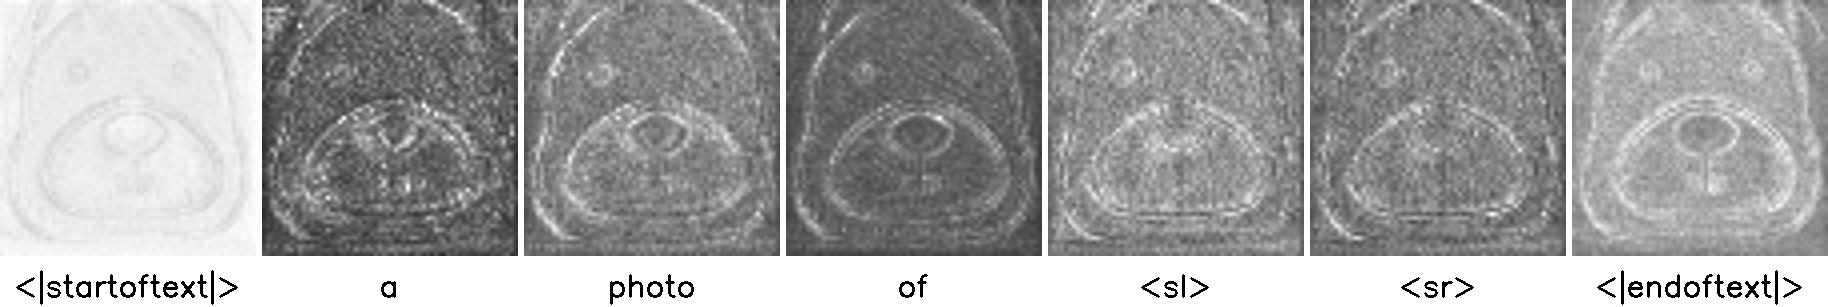

In [ ]:
prompt = TemplateManager.get_random_template("IMG")
prompt = "a photo of {}".format("<sl> <sr>")
result = analyze_attention_map(prompt)

  0%|          | 0/1 [00:00<?, ?it/s]

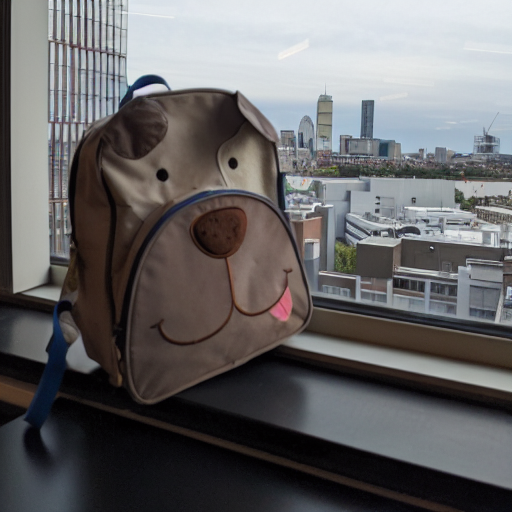

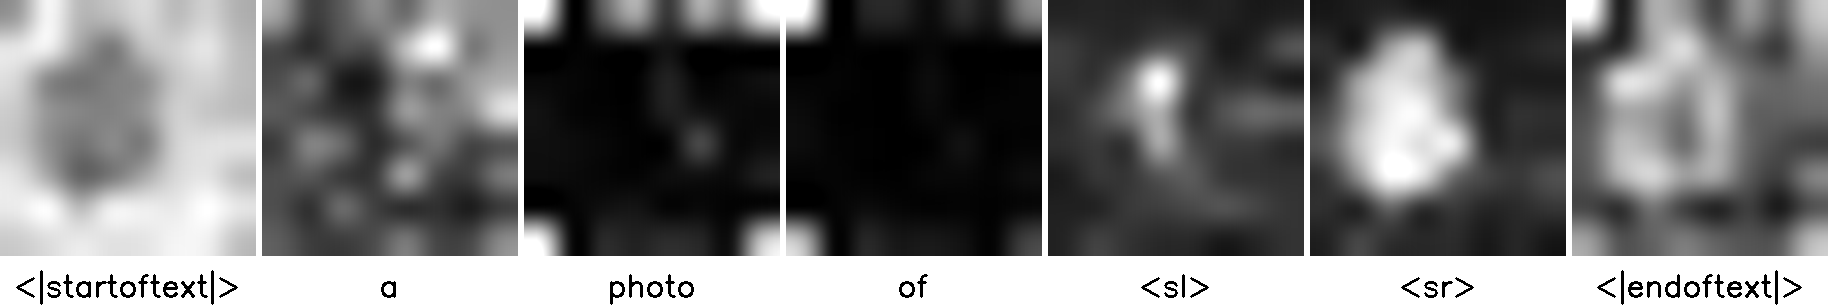

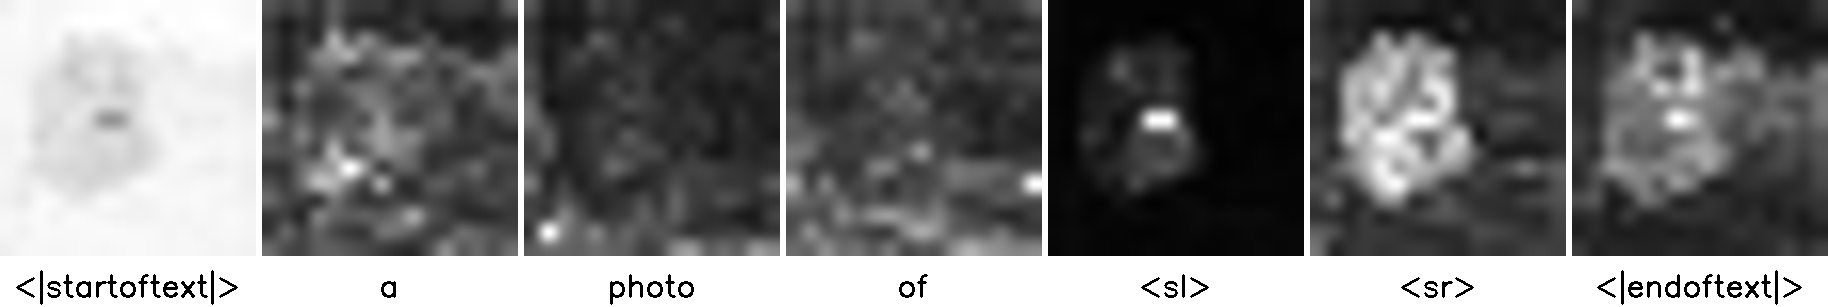

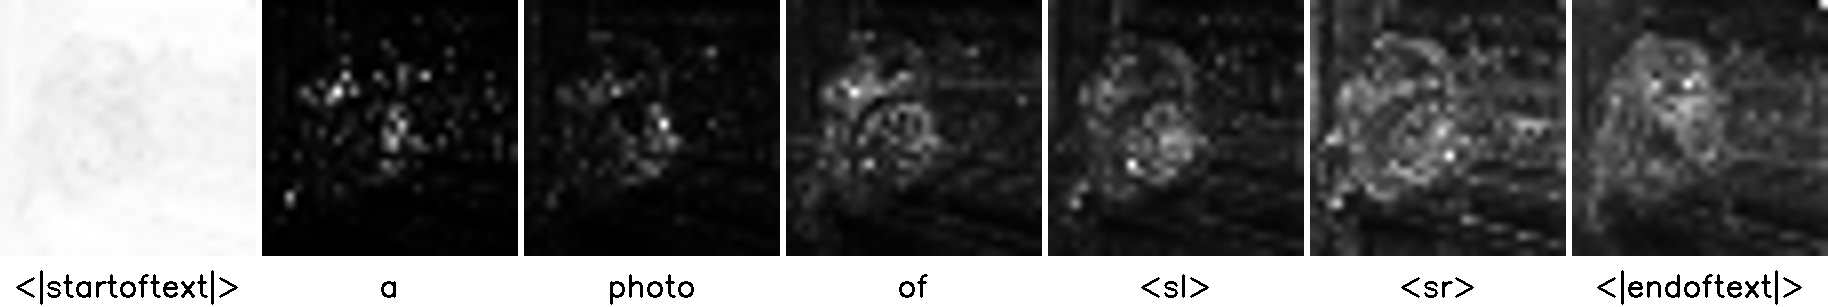

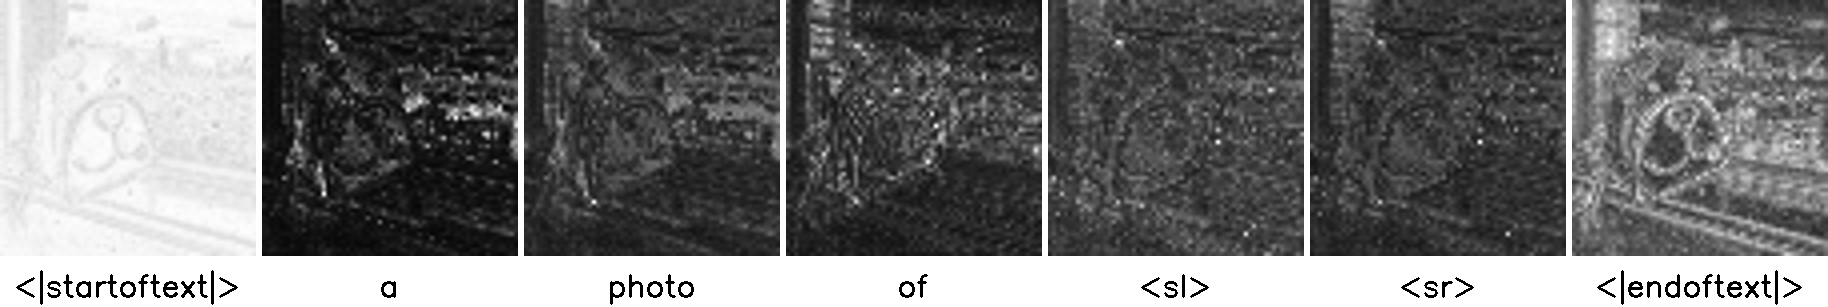

In [ ]:
prompt = TemplateManager.get_random_template("IMG")
prompt = "a photo of {}".format("<sl> <sr>")
# prompt = "a photo of the {}".format("building dog")
result = analyze_attention_map(prompt, origin_img_path)

# Analysis

In [13]:
def take_attention(attn_img, attn_loc, attn_unit):
    return attn_img[attn_loc[0]*attn_unit:(attn_loc[0]+1)*attn_unit, 
                    attn_loc[1]*attn_unit:(attn_loc[1]+1)*attn_unit]

In [20]:
base_path = "/home/jack/Code/Research/instree_analysis/experiment_image/scores"
exp_path = "/home/jack/Code/Research/instree_analysis/experiments"
# dataset_name = "InsData_clip"
dataset_name = "BackData_clip"

exp_names = list_exp_names(dataset_name, exp_path)
cpt_names = list_concept_names(dataset_name)

===== Experiment names for BackData_clip: =====
0 0_InspirationTree
1 1_Proposed
===== Total experiments: 2 =====
===== Concept names for BackData_clip: =====
backpack_dog
red_teapot
things_cup2
===== Total concepts: 3 =====


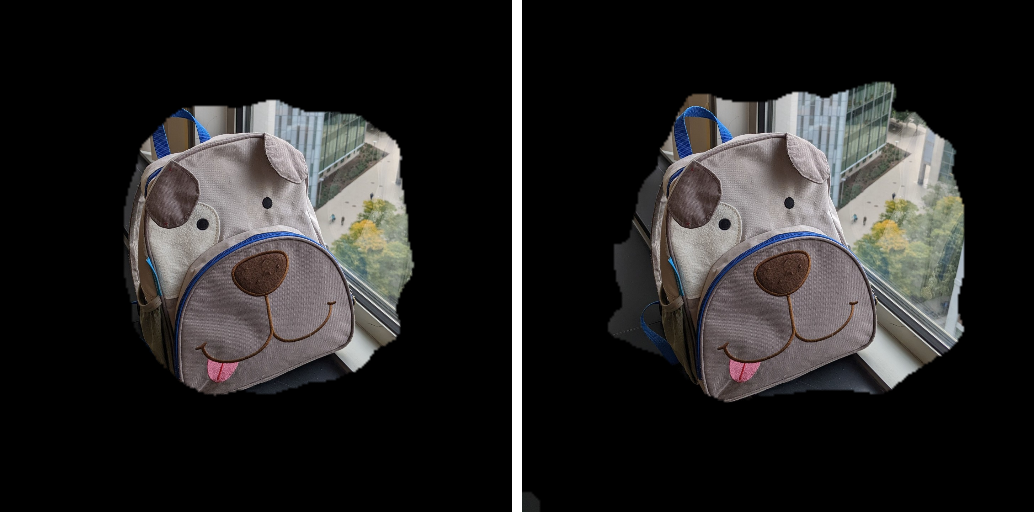

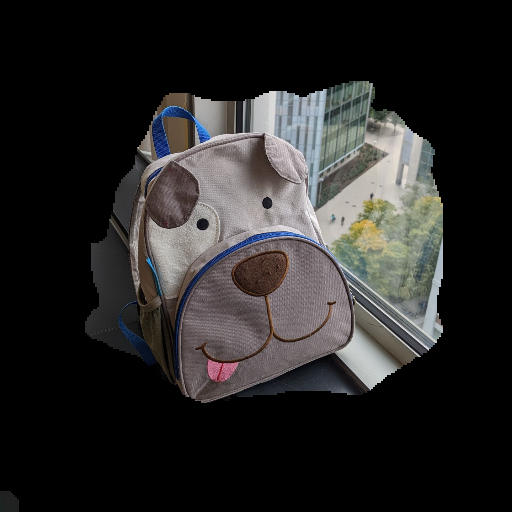

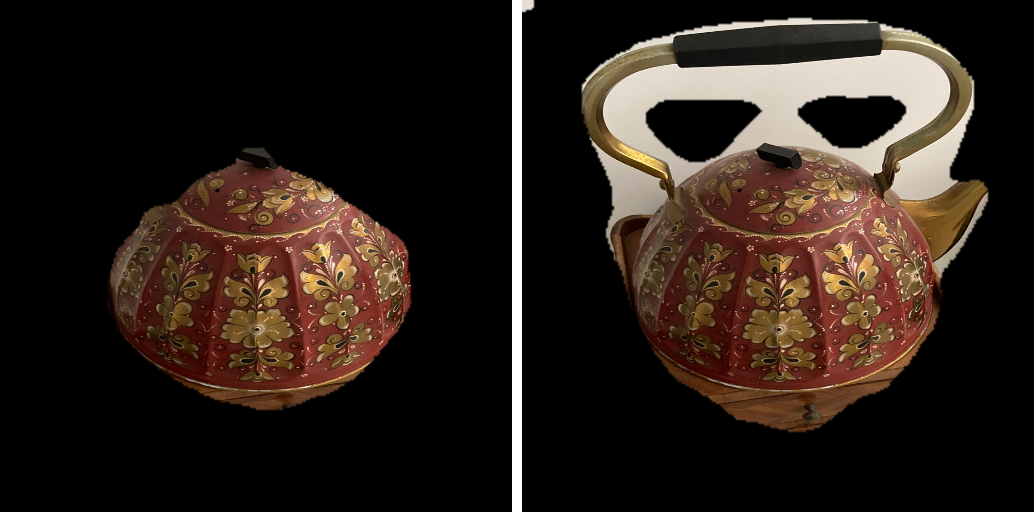

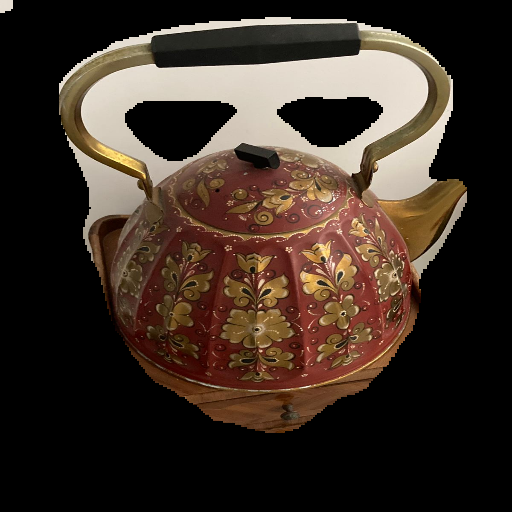

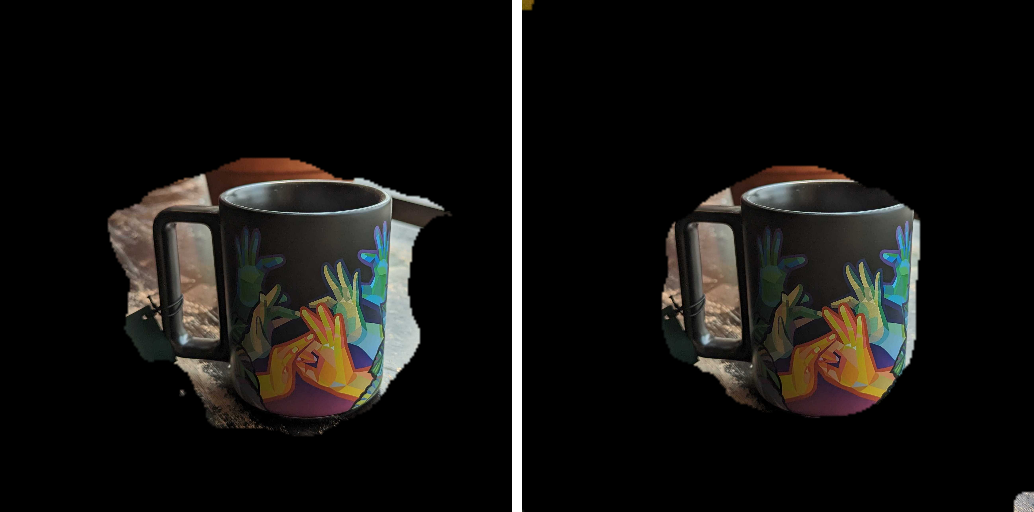

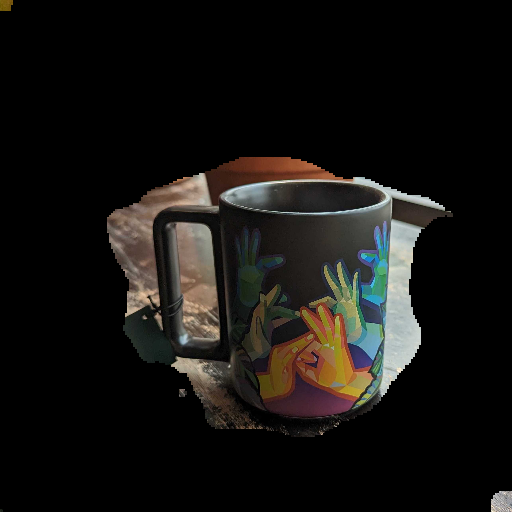

In [26]:
# For loop
exp_name = exp_names[1]
node = "v0"
seed = 0


for cpt_name in cpt_names:
    base_path = "/home/jack/Code/Research/instree_analysis"
    exp_path = f"{base_path}/experiments/{dataset_name}/{exp_name}/outputs"
    attn_path = f"{exp_path}/{cpt_name}/{node}/{node}_seed{seed}/attn"

    origin_img_path = f"{base_path}/experiment_data/{dataset_name}/{cpt_name}/v0/"
    img_names = os.listdir(origin_img_path)
    origin_img_path += random.choice(img_names)

    step = 950
    batch = 0
    attn_loc = (0, 0)
    attn_unit = 256
    res = attn_unit * 2
    # attn_img_path = f"{attn_path}/{step}_{batch}_ema.png"
    attn_img_path = f"{attn_path}/{step}_{batch}_ema_otsu.png"

    origin_img = load_image(origin_img_path).astype(np.float32)
    origin_img = resize(origin_img, res)
    origin_img = horizontal_filp(origin_img)
    mask = load_image(attn_img_path)

    v1_mask = resize(take_attention(mask, (0,0), attn_unit), res)
    v2_mask = resize(take_attention(mask, (1,0), attn_unit), res)

    view_images([v1_mask / 255 * origin_img, v2_mask / 255 * origin_img])
    view_images([((v1_mask / 255 + v2_mask / 255) > 0) * origin_img])


In [16]:
dataset_name = "InsData_clip"
# dataset_name = "BackData_clip"
exp_name = "1_Proposed"
cpt_name = "canada_bear"
node = "v0"
seed = 0

base_path = "/home/jack/Code/Research/instree_analysis"
exp_path = f"{base_path}/experiments/{dataset_name}/{exp_name}/outputs"
attn_path = f"{exp_path}/{cpt_name}/{node}/{node}_seed{seed}/attn"

origin_img_path = f"{base_path}/experiment_data/{dataset_name}/{cpt_name}/v0/"
img_names = os.listdir(origin_img_path)
origin_img_path += random.choice(img_names)

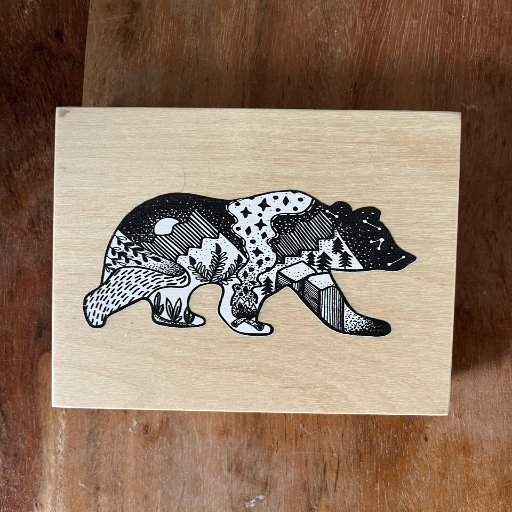

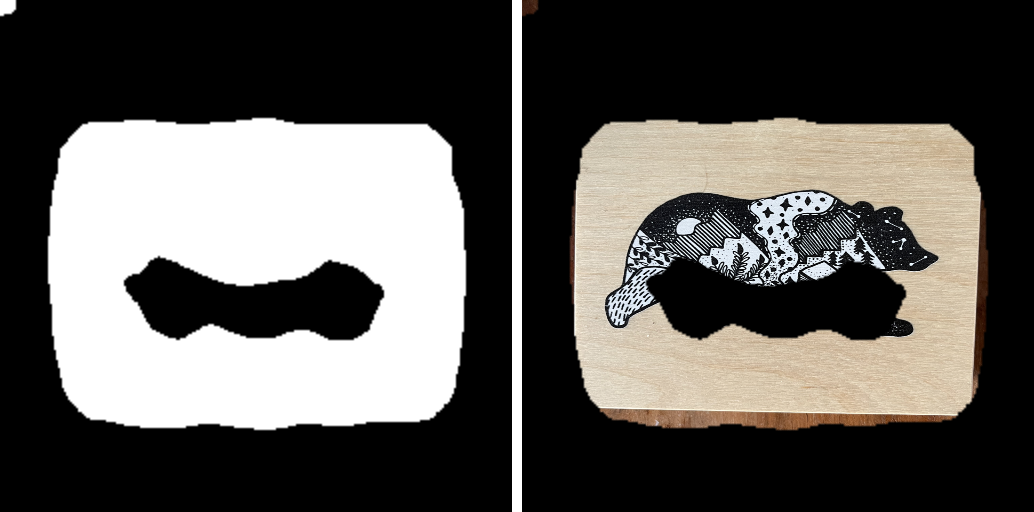

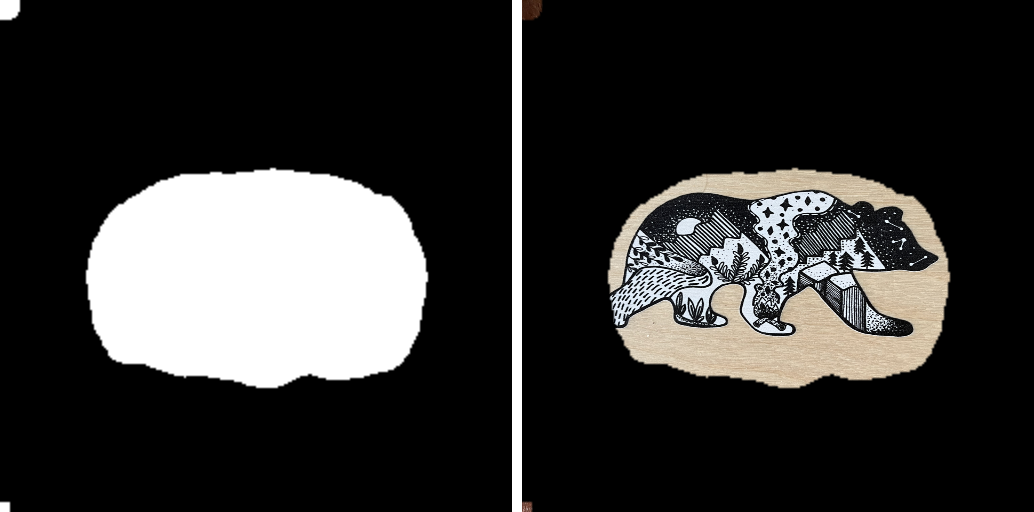

In [17]:
step = 950
batch = 0
attn_loc = (0, 0)
attn_unit = 256
res = attn_unit * 2
# attn_img_path = f"{attn_path}/{step}_{batch}_ema.png"
attn_img_path = f"{attn_path}/{step}_{batch}_ema_otsu.png"

origin_img = load_image(origin_img_path).astype(np.float32)
origin_img = resize(origin_img, res)
origin_img = horizontal_filp(origin_img)
view_images(origin_img)
mask = load_image(attn_img_path)

v1_mask = resize(take_attention(mask, (0,0), attn_unit), res)
v2_mask = resize(take_attention(mask, (1,0), attn_unit), res)

view_images([v1_mask, v1_mask / 255 * origin_img])
view_images([v2_mask, v2_mask / 255 * origin_img])

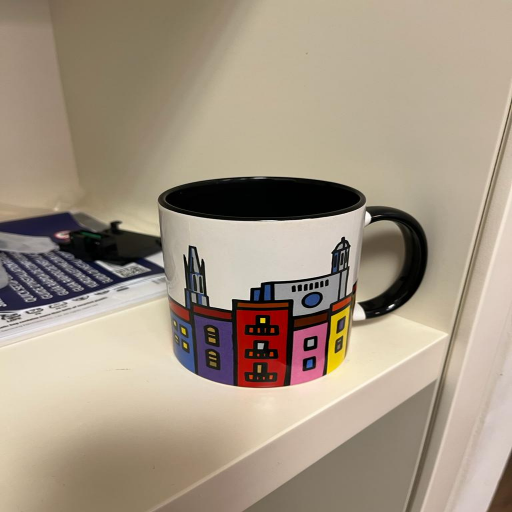

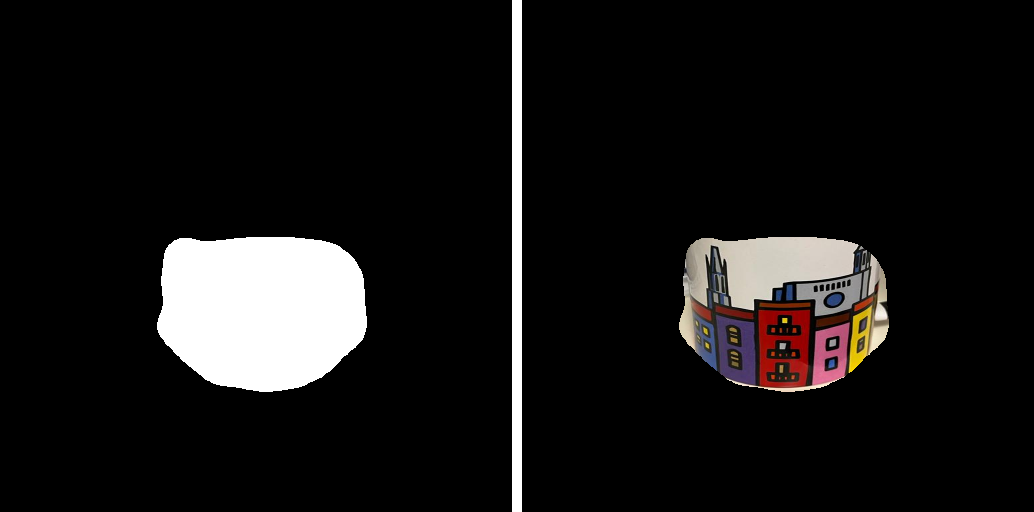

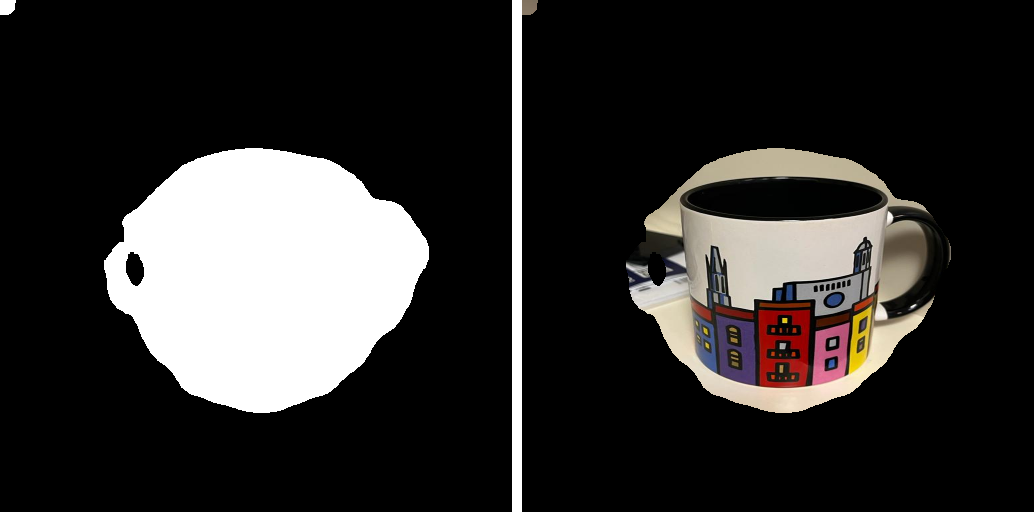

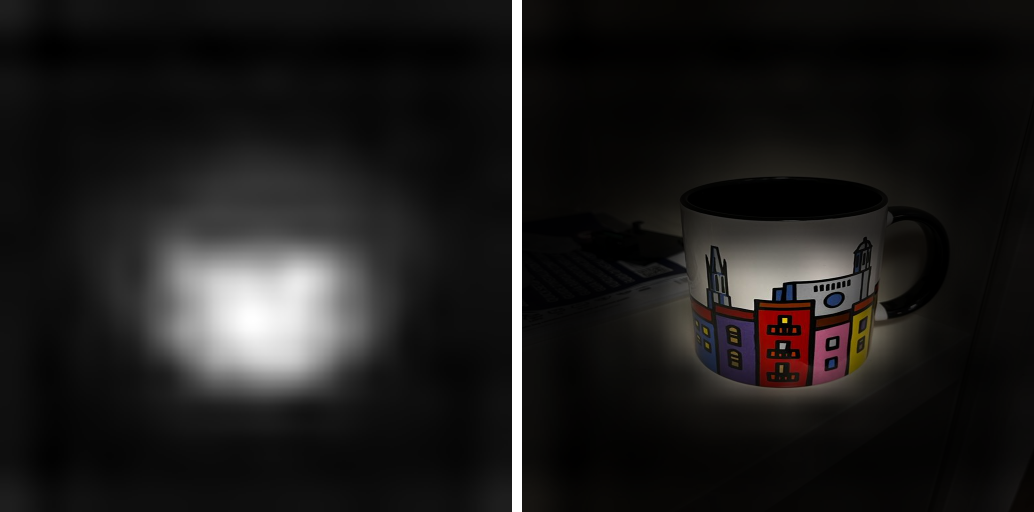

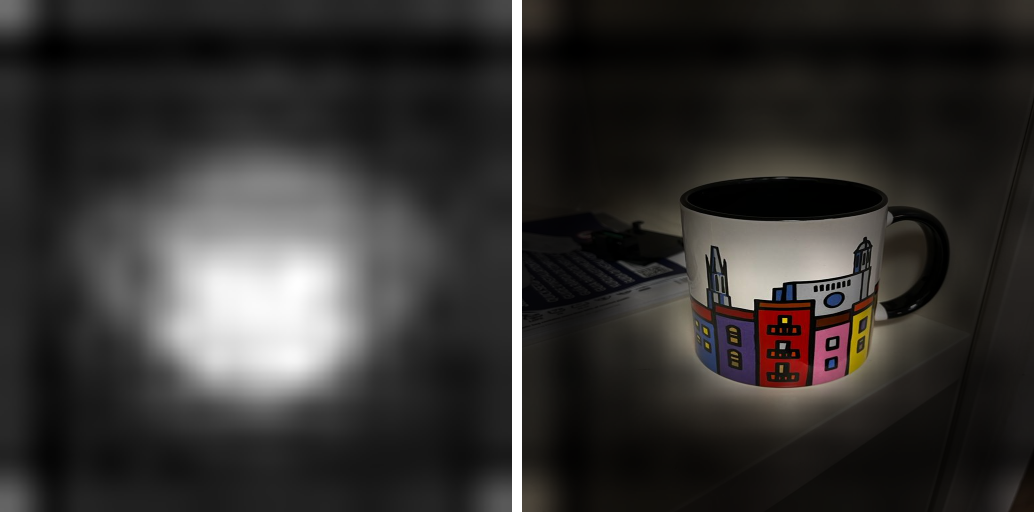

In [18]:
node = "v0"
seed = 0
step = 950
batch = 0
attn_loc = (0, 0)
attn_unit = 256
res = attn_unit * 2
dataset_name = "InsData_clip"
cpt_name = "mug_buildings"

origin_img_path = f"{base_path}/experiment_data/{dataset_name}/{cpt_name}/v0/"
img_names = os.listdir(origin_img_path)
origin_img_path += random.choice(img_names)


origin_img = load_image(origin_img_path).astype(np.float32)
origin_img = resize(origin_img, res)
# origin_img = horizontal_filp(origin_img)
view_images(origin_img)

# =====


exp_name = "1_Proposed"


base_path = "/home/jack/Code/Research/instree_analysis"
exp_path = f"{base_path}/experiments/{dataset_name}/{exp_name}/outputs"
attn_path = f"{exp_path}/{cpt_name}/{node}/{node}_seed{seed}/attn"
attn_img_path = f"{attn_path}/{step}_{batch}_ema.png"
# attn_img_path = f"{attn_path}/{step}_{batch}_ema_otsu.png"

mask = load_image(attn_img_path)
v1_mask = resize(take_attention(mask, (0,0), attn_unit), res)
v2_mask = resize(take_attention(mask, (1,0), attn_unit), res)

v1_mask_otsu = otsu_thresholding(v1_mask.astype(np.uint8))
v2_mask_otsu = otsu_thresholding(v2_mask.astype(np.uint8))


# =====
exp_name = "2_Abla_Attn_RD_EMA"

base_path = "/home/jack/Code/Research/instree_analysis"
exp_path = f"{base_path}/experiments/{dataset_name}/{exp_name}/outputs"
attn_path = f"{exp_path}/{cpt_name}/{node}/{node}_seed{seed}/attn"
attn_img_path = f"{attn_path}/{step}_{batch}_ema.png"
# attn_img_path = f"{attn_path}/{step}_{batch}_ema_otsu.png"

mask_exp = load_image(attn_img_path)
v1_mask_exp = resize(take_attention(mask_exp, (0,0), attn_unit), res)
v2_mask_exp = resize(take_attention(mask_exp, (1,0), attn_unit), res)\

v1_mask_exp_otsu = otsu_thresholding(v1_mask_exp.astype(np.uint8))
v2_mask_exp_otsu = otsu_thresholding(v2_mask_exp.astype(np.uint8))

# view_images([v1_mask, v1_mask_otsu])
# view_images([v2_mask, v2_mask_otsu])

# view_images([v1_mask_exp, v1_mask_exp_otsu])
# view_images([v2_mask_exp, v2_mask_exp_otsu])

view_images([v1_mask_otsu, v1_mask_otsu / 255 * origin_img])
view_images([v2_mask_otsu, v2_mask_otsu / 255 * origin_img])

view_images([v1_mask_exp, v1_mask_exp / 255 * origin_img])
view_images([v2_mask_exp, v2_mask_exp / 255 * origin_img])